# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
argopy.set_options(mode='expert')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

In [2]:
def get_dataow(file_path):
    
    # load from .met file
    mat_dict_load = sp.io.loadmat(file_path)
    
    #create a xarray dataset
    ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

    return ds_ref

__Input__

In [3]:
float_WMO = 3901915
prof_num = 66

## 1. Load float profile

using argopy

In [4]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [5]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 379, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 ... 374 375 376 377 378
    TIME                      (N_PROF) datetime64[ns] 2017-12-08T05:40:19.999...
    LATITUDE                  (N_PROF) float64 -37.34
    LONGITUDE                 (N_PROF) float64 18.66
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 5
    CYCLE_NUMBER              (N_PROF) int64 66
    DATA_CENTRE               (N_PROF) <U2 'BO'
    DATA_MODE                 (N_PROF, N_LEVELS) <U1 'D' 'R' 'D' ... 'D' 'D' 'D'
    DATA_STATE_INDICATOR      (N_PROF, N_LEVELS) <U4 '2C  ' '2B  ' ... '2C  '
    DC_REFERENCE              (N_PROF) <U32 '                                '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 '5900A01                         '
    FLOAT_SERIAL_NO           (N_PROF) <U32 'AI2600-16FR078                  '
    PI_NAME                   (N_PROF) <U64 'Romain Cancouet                 ...
    PLATFORM_NUMBER           (N_PROF) int64 3901915
    PLATFORM_TYPE             (N_PROF) <U32 'ARVOR                           '
    POSITIONING_SYSTEM        (N_PROF) <U8 'GPS     '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 2.9 0.4 ... 2013.8
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 2.9 nan ... 2013.8
    PRES_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 2.4 nan 2.4 ... 2.4 2.4
    PRES_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF, N_LEVELS) <U1 'A' 'F' 'A' ... 'A' 'A' 'A'
    PROFILE_TEMP_QC           (N_PROF, N_LEVELS) <U1 'A' 'C' 'A' ... 'A' 'A' 'A'
    PROJECT_NAME              (N_PROF) <U64 'MOCCA_EU                        ...
    PSAL                      (N_PROF, N_LEVELS) float32 35.429 ... 34.823
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 35.429 nan ... 34.823
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.03 nan ... 0.03 0.03
    PSAL_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    PSAL_QC                   (N_PROF, N_LEVELS) int64 1 3 1 3 1 3 ... 1 1 1 1 1
    TEMP                      (N_PROF, N_LEVELS) float32 20.756 20.758 ... 2.59
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 20.756 nan ... 2.59
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.002 nan ... 0.002
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    TEMP_QC                   (N_PROF, N_LEVELS) int64 1 3 1 1 1 1 ... 1 1 1 1 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2017-12-08T05:57:27.999...
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF, N_LEVELS) <U256 'Primary sampling: ave...
    WMO_INST_TYPE             (N_PROF) int64 844
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/10/19
    Fetched_constraints:  phy;WMO3901915_CYC66
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/bodc/3901...
    history:              Transformed with point2profile

In [6]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [7]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 379, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 ... 374 375 376 377 378
    TIME                      (N_PROF) datetime64[ns] 2017-12-08T05:40:19.999...
    LATITUDE                  (N_PROF) float64 -37.34
    LONGITUDE                 (N_PROF) float64 18.66
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 5
    CYCLE_NUMBER              (N_PROF) int64 66
    DATA_CENTRE               (N_PROF) <U2 'BO'
    DATA_MODE                 (N_PROF, N_LEVELS) <U1 'D' 'R' 'D' ... 'D' 'D' 'D'
    DATA_STATE_INDICATOR      (N_PROF, N_LEVELS) <U4 '2C  ' '2B  ' ... '2C  '
    DC_REFERENCE              (N_PROF) <U32 '                                '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 '5900A01                         '
    FLOAT_SERIAL_NO           (N_PROF) <U32 'AI2600-16FR078                  '
    PI_NAME                   (N_PROF) <U64 'Romain Cancouet                 ...
    PLATFORM_NUMBER           (N_PROF) int64 3901915
    PLATFORM_TYPE             (N_PROF) <U32 'ARVOR                           '
    POSITIONING_SYSTEM        (N_PROF) <U8 'GPS     '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 2.9 0.4 ... 2013.8
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 2.9 nan ... 2013.8
    PRES_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 2.4 nan 2.4 ... 2.4 2.4
    PRES_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF, N_LEVELS) <U1 'A' 'F' 'A' ... 'A' 'A' 'A'
    PROFILE_TEMP_QC           (N_PROF, N_LEVELS) <U1 'A' 'C' 'A' ... 'A' 'A' 'A'
    PROJECT_NAME              (N_PROF) <U64 'MOCCA_EU                        ...
    PSAL                      (N_PROF, N_LEVELS) float32 35.429 ... 34.823
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 35.429 nan ... 34.823
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.03 nan ... 0.03 0.03
    PSAL_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    PSAL_QC                   (N_PROF, N_LEVELS) int64 1 3 1 3 1 3 ... 1 1 1 1 1
    TEMP                      (N_PROF, N_LEVELS) float32 20.756 20.758 ... 2.59
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 20.756 nan ... 2.59
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.002 nan ... 0.002
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) int64 1 0 1 0 1 0 ... 1 1 1 1 1
    TEMP_QC                   (N_PROF, N_LEVELS) int64 1 3 1 1 1 1 ... 1 1 1 1 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2017-12-08T05:57:27.999...
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF, N_LEVELS) <U256 'Primary sampling: ave...
    WMO_INST_TYPE             (N_PROF) int64 844
    ptmp                      (N_PROF, N_LEVELS) float32 20.755451 ... 2.4427688
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/10/19
    Fetched_constraints:  phy;WMO3901915_CYC66
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/bodc/3901...
    history:              Transformed with point2profile

In [8]:
ds_f.PRES.max().values

array(2013.80004883)

## 2. Load reference data

__data without class selection__

In [9]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_noclass.mat'
ds_ref = get_dataow(file_path)
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 1010, n_profiles: 310)
Coordinates:
    long     (n_profiles) float64 16.77 17.14 16.47 18.76 ... 31.22 31.62 33.45
    lat      (n_profiles) float64 -35.72 -37.06 -35.46 ... -40.74 -41.81 -42.26
    dates    (n_profiles) datetime64[ns] 2003-01-01 2007-01-01 ... 2018-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 10.0 5.0 5.0 5.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 16.19 19.32 17.13 ... nan nan nan
    sal      (n_pres, n_profiles) float64 35.5 35.35 35.49 35.61 ... nan nan nan

interpolation to standard levels

In [ ]:
max_depth = 1000
std_lev = np.arange(0,max_depth)
ds_refi = interpolate_standard_levels(ds_ref, std_lev)
ds_refi

__data with class selection__

In [10]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_k5.mat'
ds_ref_class = get_dataow(file_path)
ds_ref_class

<xarray.Dataset>
Dimensions:  (n_pres: 1010, n_profiles: 196)
Coordinates:
    long     (n_profiles) float64 16.77 17.14 16.47 19.0 ... 31.22 31.62 33.45
    lat      (n_profiles) float64 -35.72 -37.06 -35.46 ... -40.74 -41.81 -42.26
    dates    (n_profiles) datetime64[ns] 2003-01-01 2007-01-01 ... 2018-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 10.0 5.0 5.0 5.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 16.19 19.32 17.13 ... nan nan nan
    sal      (n_pres, n_profiles) float64 35.5 35.35 35.49 35.51 ... nan nan nan

interpolation to standard levels

In [ ]:
max_depth = 1000
std_lev = np.arange(0,max_depth)
ds_ref_classi = interpolate_standard_levels(ds_ref_class, std_lev)
ds_ref_classi

Calculate mean and std

In [ ]:
mean_ptmp = np.nanmean(ds_refi['ptmp'], axis=0)
std_ptmp = np.nanstd(ds_refi['ptmp'], axis=0)
mean_sal = np.nanmean(ds_refi['sal'], axis=0)
std_sal = np.nanstd(ds_refi['sal'], axis=0)

mean_ptmp_class = np.nanmean(ds_ref_classi['ptmp'], axis=0)
std_ptmp_class = np.nanstd(ds_ref_classi['ptmp'], axis=0)
mean_sal_class = np.nanmean(ds_ref_classi['sal'], axis=0)
std_sal_class = np.nanstd(ds_ref_classi['sal'], axis=0)

## 3. Plots

__Potential temperature__

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_ptmp + std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[0].plot(mean_ptmp - std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--');
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_ptmp_class + std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_ptmp_class - std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

__Salinity__

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_sal, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_sal + std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset')
ax[0].plot(mean_sal - std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--')
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_sal_class + std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_sal_class - std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

Print all profiles

Text(0.5, 1.0, 'PCM-based reference')

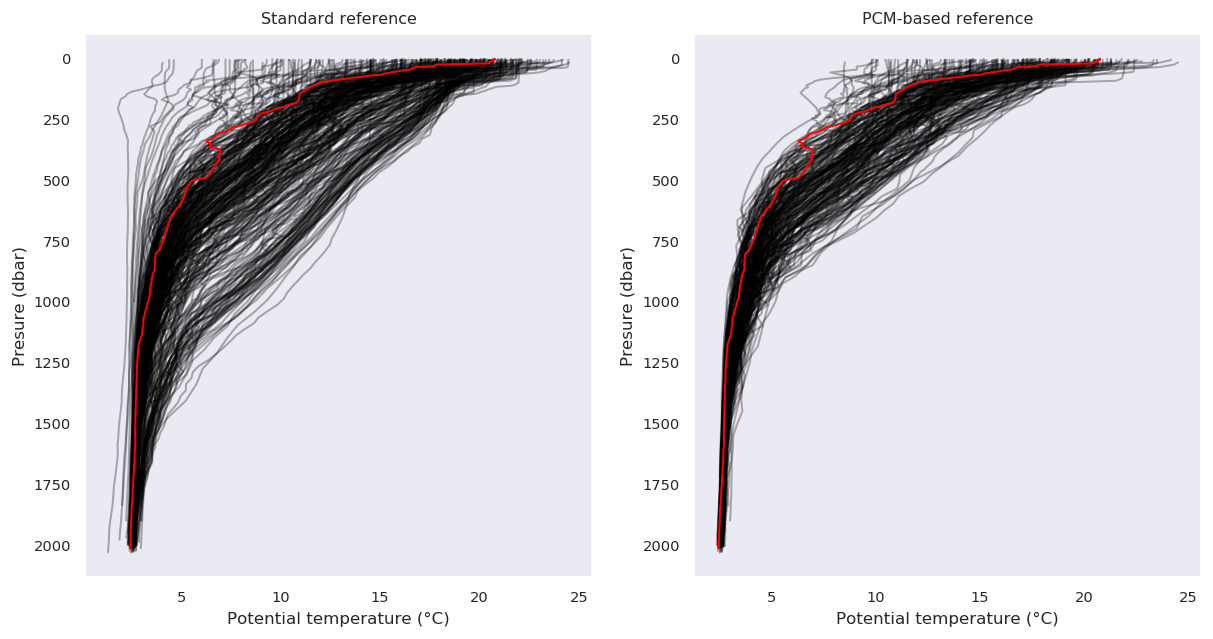

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['ptmp'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['ptmp'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Text(0.5, 1.0, 'PCM-based reference')

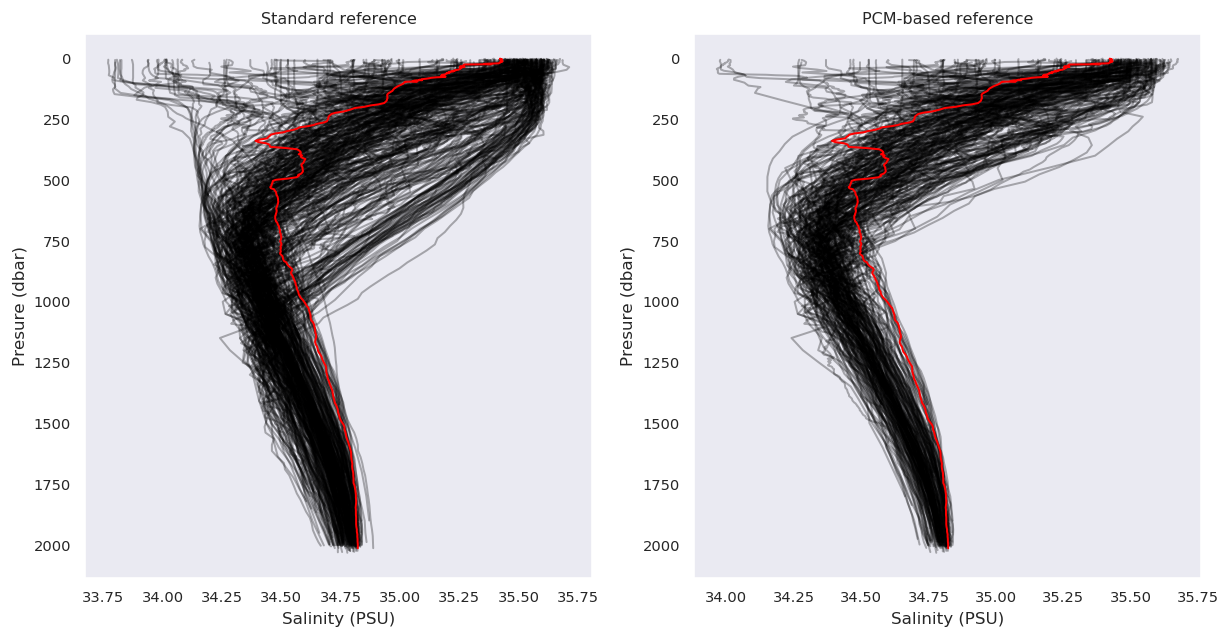

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['sal'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['sal'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Plot ellipses with and without class selection

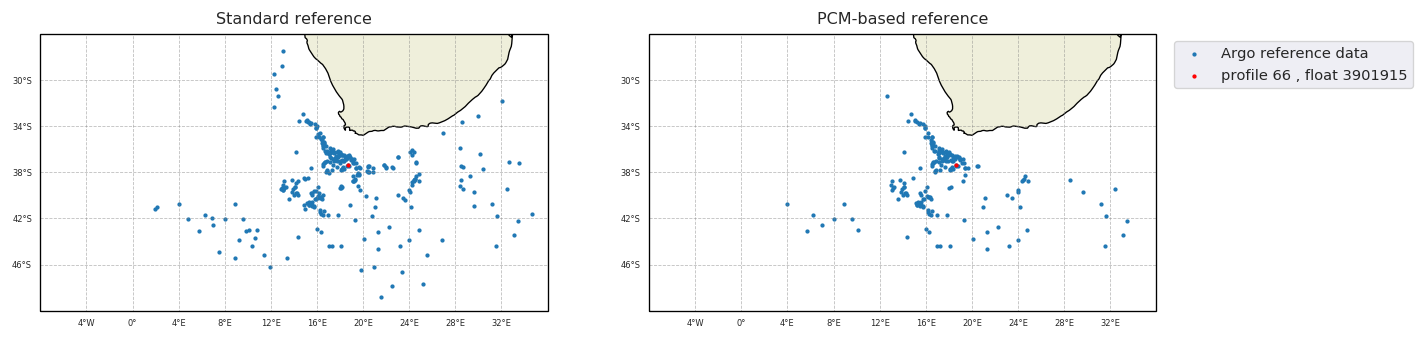

In [14]:
#selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

# without class selection
p1 = ax[0].scatter(ds_ref['long'], ds_ref['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[0].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[0].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[0].gridlines(crs=ax[0].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].set_title('Standard reference')
ax[0].set_xlim([-8,36])
ax[0].set_ylim([-50,-26])

# with class selection
p1 = ax[1].scatter(ds_ref_class['long'], ds_ref_class['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[1].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[1].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[1].gridlines(crs=ax[1].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[1].set_title('PCM-based reference')
ax[1].set_xlim([-8,36])
ax[1].set_ylim([-50,-26])

ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plot number of reference profiles per profile

In [ ]:
# load standard reference data
file_path1 = 'mat_files/3901915_n_ref_prof_noclass.mat'
mat_dict = sp.io.loadmat(file_path1)
# load standard PCM based data
file_path2 = 'mat_files/3901928_n_ref_prof_k4_change_order.mat'
mat_dict_class = sp.io.loadmat(file_path2)

In [ ]:
labels = np.arange(0,len(mat_dict['n_ref_prof'][0])+1,10)

x = np.arange(1,len(mat_dict['n_ref_prof'][0])+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.plot(x, mat_dict['n_ref_prof'][0], 'o-', label='Standard reference')
rects2 = ax.plot(x, mat_dict_class['n_ref_prof'][0], 'o-', label='PCM-based reference')

ax.set_ylabel('# of reference profiles', fontsize=10)
ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=10)
ax.set_title('Reference profiles per float profile')
ax.set_xticks(labels)
ax.set_xlim([0.5,len(mat_dict['n_ref_prof'][0])+0.5])
#ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')